In [1]:
REPORT_PATH = "../out/reports/wfp_full__model_svmrbf__dummies_3__tracelen_500__iter_5000.pkl"
DEF_SUMMARY_PATH = "../out/wfp_defenses/wfp_defense_compare.csv"

FIGS_PATH = '../out/images'
FIGWIDTH = 8.5
FIGHEIGHT = 6.5
SAVE_PLOTS = True

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('..')

In [4]:
import warnings
warnings.filterwarnings("ignore")

import os
import pickle
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.patches as mpatches
import tqdm

from joypy import joyplot

from scipy.stats import entropy
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
from sklearn.feature_selection import f_regression
from sklearn.cross_validation import train_test_split

from trickster.domain.wfp import load_data, extract

/home/bogdan/Workspace/trickster/venv/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
import plot_params

In [6]:
def save_fig(fig, name_template, *args, **kwargs):
    fig.savefig(os.path.join(FIGS_PATH, name_template.format(*args, **kwargs)))

In [7]:
with open(REPORT_PATH, 'rb') as f:
    adv_results = pickle.load(f)

In [8]:
def_summary = pd.read_csv(DEF_SUMMARY_PATH)
def_summary = def_summary.rename(columns={'idx': 'filename'})

In [9]:
def_summary.defense.unique()

array(['Original', 'CS BUFLO', 'Tamaraw', 'Decoy', 'WTF-PAD'],
      dtype=object)

In [10]:
gs_summary = pd.DataFrame(columns=[
    'filename', 'trace len', 'defense', 'added packets', 'class', 'svm pred', 'lr pred'
])
for _, row in adv_results.iterrows():
    if row.found:
        gs_summary = gs_summary.append({
            'filename': row.filename,
            'trace len': len(row.adv_x),
            'added packets': len(row.adv_x) - len(row.x),
            'svm pred': 1,
            'defense': 'Ours'
        }, ignore_index=True)
    else:
        gs_summary = gs_summary.append({
            'filename': row.filename,
            'trace len': len(row.x),
            'svm pred': 0,
            'defense': 'Ours'
        }, ignore_index=True)

In [11]:
all_defenses_summary = gs_summary.append(def_summary.query("defense != 'Original'"))

In [12]:
GS_DEF_NAME = "Our baseline"

In [13]:
success_data = pd.DataFrame(columns=["defense", "success"])
success_data.defense = all_defenses_summary.defense.replace({"Ours": GS_DEF_NAME})
success_data.success = all_defenses_summary["svm pred"] == 1 | (~all_defenses_summary["added packets"].isna())
success_data.head()

,defense,success
0,Our baseline,True
1,Our baseline,True
2,Our baseline,True
3,Our baseline,True
4,Our baseline,True


In [14]:
overhead_data = pd.DataFrame()
for _, row in gs_summary.iterrows():
    t = def_summary.query("filename=='%s' and defense!='Original'" % row.filename)
    def_overheads = t.pivot_table(
        columns="defense",
        values="added packets",
        index="filename"
    )
    adv_ex_overhead = pd.DataFrame(
        {GS_DEF_NAME: row["added packets"] if row['svm pred'] == 1 else 0},
        index=[row["filename"]]
    )
    full_overhead = pd.concat([adv_ex_overhead, def_overheads], axis=1)
    overhead_data = overhead_data.append(full_overhead)
    
overhead_data.head()

,CS BUFLO,Decoy,Our baseline,Tamaraw,WTF-PAD
10-25,410.0,1065.0,12,2414.0,1644.0
81-17,348.0,1485.0,3,1416.0,506.0
81-12,97.0,1834.0,6,1021.0,46.0
10-66,290.0,2645.0,9,1722.0,422.0
10-47,163.0,1512.0,9,1223.0,762.0


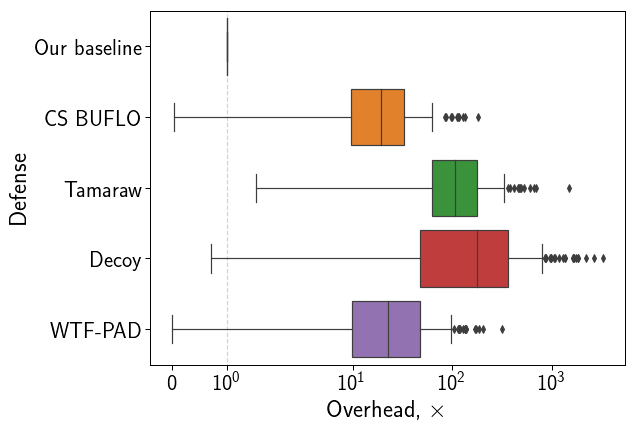

In [15]:
clean_overhead_data = overhead_data.dropna()
increase_data = pd.DataFrame()
for defense in [GS_DEF_NAME, 'CS BUFLO', 'Tamaraw', 'Decoy', 'WTF-PAD']:
    df = clean_overhead_data
    increase_data = increase_data.append(
        pd.concat({
            "increase": df[defense] / df[GS_DEF_NAME],
            "defense": pd.Series([defense] * len(df), index=df.index)
        }, axis=1), ignore_index=True
    )
increase_data = increase_data[increase_data["increase"] != np.inf]
    
fig, ax = plt.subplots()
sns.boxplot(data=increase_data, x="increase", y="defense", ax=ax)
ax.set_xscale("symlog")

ax.vlines(1, -1, 10, linestyles="--", color="lightgray")

ax.set_xlabel("Overhead, $\\times$")
ax.set_ylabel("Defense")

fig.set_figwidth(FIGWIDTH)
fig.set_figheight(FIGHEIGHT)

if SAVE_PLOTS:
    save_fig(fig, 'wfp_defs_overhead_comparison.pdf')

In [16]:
overhead_delta_data = pd.DataFrame()
for defense in ['CS BUFLO', 'Tamaraw', 'Decoy', 'WTF-PAD']:
    df = overhead_data
    bad_baseline = df[defense] < df[GS_DEF_NAME]
    success_mask = (def_summary["svm pred"] == 1) & (def_summary["defense"] == defense)
    success_filenames = def_summary[success_mask]["filename"]
    overhead_delta_data = overhead_delta_data.append(
        pd.concat({
            "bad_baseline": bad_baseline,
            "success": pd.Series(df.index.isin(success_filenames), index=df.index),
            "defense": pd.Series([defense] * len(df), index=df.index)
        }, axis=1), ignore_index=True
    )

overhead_delta_data.pivot_table(columns="defense")

defense,CS BUFLO,Decoy,Tamaraw,WTF-PAD
bad_baseline,0.047431,0.019763,0.00000,0.051383
success,0.478261,0.905138,0.83004,0.434783


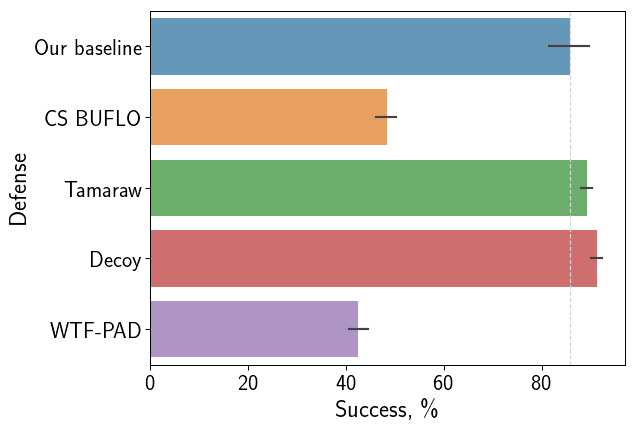

In [17]:
fig, ax = plt.subplots()

baseline_mean = success_data.query("defense == '%s'" % GS_DEF_NAME).success.mean()
ax.vlines(baseline_mean * 100, -.5, 4.5, linestyles="--", color="lightgray")
sns.barplot(
    data=success_data, x="success", y="defense",
    estimator=lambda vals: vals.mean() * 100,
    alpha=0.75,
    ax=ax)

ax.set_xlabel("Success, \%")
ax.set_ylabel("Defense")

fig.set_figwidth(FIGWIDTH)
fig.set_figheight(FIGHEIGHT)

if SAVE_PLOTS:
    save_fig(fig, 'wfp_defs_success_comparison.pdf')